In [1]:
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr

from eofs.xarray import Eof

import matplotlib.path as mpath
import matplotlib.pyplot as plt

# parameters for setting circular cutoff for Southern Ocean plots
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)

In [40]:
fpath = {'CM4':  '/archive/Katherine.Turner/xanadu_mom6_20220703/CM4_piControl_C_restartyear148/gfdl.ncrc5-intel22-prod-openmp/pp/atmos/ts/monthly/5yr',
         'ESM4': '/archive/Katherine.Turner/fre/FMS2021.02_mom6_ESM4_v1.0.3/ESM4_piControl_D/gfdl.ncrc5-intel23-prod-openmp/pp/atmos/ts/monthly/5yr'}

mod = 'CM4'
ds = xr.open_mfdataset(f'{fpath[mod]}/atmos*slp.nc', use_cftime=True)

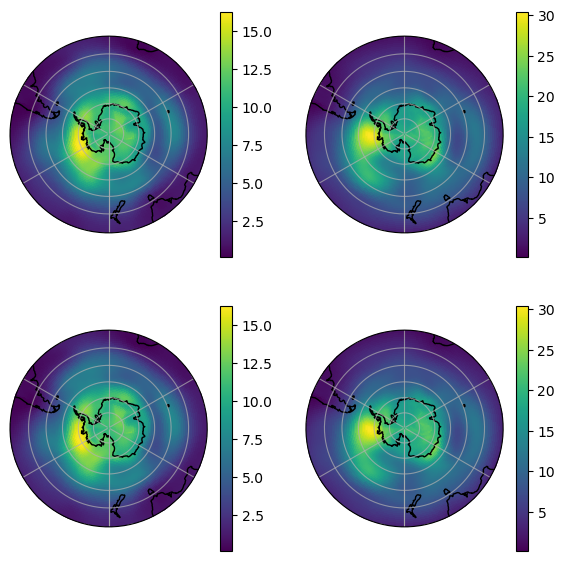

In [32]:
fig, axs = plt.subplots(nrows=2, ncols=2,
                        figsize=(7,7),
                        subplot_kw={'projection': ccrs.SouthPolarStereo()})

for i, m in enumerate(mods):
    ds = xr.open_mfdataset(f'{fpath[mod]}/atmos*slp.nc', use_cftime=True)
    slp = ds.slp.sel(lat=slice(-90,-20)).resample(time='QS-DEC').mean()
    
    idx_djf = slp.time.dt.season == 'DJF'
    idx_jja = slp.time.dt.season == 'JJA'
    
    slp[idx_djf,:,:].var(dim='time').plot(ax=axs[i][0],
                                         transform=ccrs.PlateCarree(), 
                                         cbar_kwargs={'label':''})

    slp[idx_jja,:,:].var(dim='time').plot(ax=axs[i][1],
                                         transform=ccrs.PlateCarree(), 
                                         cbar_kwargs={'label':''})
    
    for j in range(2):
        axs[i][j].set_extent([-180, 180, -90, -30], ccrs.PlateCarree())
        axs[i][j].gridlines(alpha=0.7)
        axs[i][j].set_boundary(circle, transform=axs[i][j].transAxes)
        axs[i][j].coastlines()

CM4 DJF EOF frac. of variance: [0.531675]
1
CM4 JJA EOF frac. of variance: [0.40295824]
-1


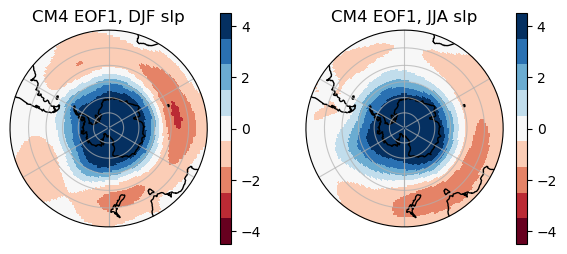

In [41]:
fig, axs = plt.subplots(nrows=1, ncols=2,
                        figsize=(7,3),
                        subplot_kw={'projection': ccrs.SouthPolarStereo()})

s = ['DJF', 'JJA']

for i in range(2):
    slp = ds.slp.sel(lat=slice(-90,-20)).resample(time='QS-DEC').mean()[i*2::4,:,:]

    slp_anom = slp - slp.mean(dim='time')
    slp_anom = slp_anom.compute()

    coslat = np.cos(np.deg2rad(slp_anom.coords['lat'].values)).clip(0., 1.)
    wgts = np.sqrt(coslat)[..., np.newaxis]

    solver = Eof(slp_anom, weights=wgts)
    eof1 = solver.eofsAsCovariance(neofs=1)
    
    print(f"{mod} {s[i]} EOF frac. of variance: {solver.varianceFraction(neigs=1).data}")
    
    if eof1[:,0,0] < 0:
        c = -1
    else:
        c = 1
        
    print(c)

    (c*eof1).plot(ax=axs[i],
              transform=ccrs.PlateCarree(), 
              cmap=plt.get_cmap('RdBu', 9), 
              vmin=-4.5, vmax=4.5, extend='neither',
              cbar_kwargs={'label':''})

    axs[i].set_title(f'{mod} EOF1, {s[i]} slp')
    
    axs[i].set_extent([-180, 180, -90, -30], ccrs.PlateCarree())
    axs[i].gridlines(alpha=0.7)
    axs[i].set_boundary(circle, transform=axs[i].transAxes)
    axs[i].coastlines()
    
    pcs = solver.pcs(npcs=1, pcscaling=1)
    #pcs.to_netcdf(f'/work/Katherine.Turner/smaller_projects/hifreq-variability/data/{mod}_{s[i]}_pc1.nc')
    
#plt.savefig(f'/work/Katherine.Turner/smaller_projects/hifreq-variability/figures/{mod}_slp_EOFs.png', format='png', dpi=100)

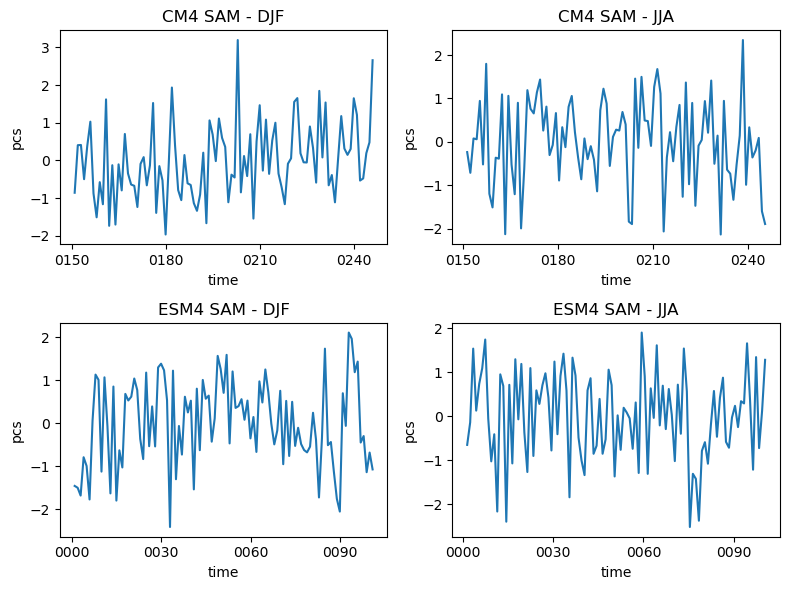

In [14]:
fig, axs = plt.subplots(nrows=2, ncols=2,
                        figsize=(8,6)
                       )

mods = ['CM4', 'ESM4']

for i, m in enumerate(mods):
    ds_djf = xr.open_dataset(f'/work/Katherine.Turner/smaller_projects/hifreq-variability/data/{m}_DJF_pc1.nc', use_cftime=True)
    ds_jja = xr.open_dataset(f'/work/Katherine.Turner/smaller_projects/hifreq-variability/data/{m}_JJA_pc1.nc', use_cftime=True)
    
    ds_djf.pcs[:,0].plot(ax=axs[i][0])
    axs[i][0].set_title(f'{m} SAM - DJF')
    ds_jja.pcs[:,0].plot(ax=axs[i][1])
    axs[i][1].set_title(f'{m} SAM - JJA')
    
plt.tight_layout()

plt.savefig('/work/Katherine.Turner/smaller_projects/hifreq-variability/figures/SAM_pcs.png',
           format='png',
           dpi=100)

In [27]:
m = 'ESM4'

ds_djf = xr.open_dataset(f'/work/Katherine.Turner/smaller_projects/hifreq-variability/data/{m}_DJF_pc1.nc', use_cftime=True)
ds_jja = xr.open_dataset(f'/work/Katherine.Turner/smaller_projects/hifreq-variability/data/{m}_JJA_pc1.nc', use_cftime=True)

In [28]:
corr = np.corrcoef(ds_jja.pcs[1:,0],ds_djf.pcs[1:-1,0])
corr

array([[ 1.        , -0.14159204],
       [-0.14159204,  1.        ]])

In [29]:
corr = np.corrcoef(ds_jja.pcs[:-1,0],ds_djf.pcs[1:-1,0])
corr

array([[1.        , 0.22593213],
       [0.22593213, 1.        ]])